In [11]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import ast
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

advan_path = 'data/Atlanta_data/atlanta-2019-03.csv'
acs_path = 'data/Atlanta_data/ACS_atlanta/ACSDT5Y2018.B01001-Data.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Read the data
advan_data = pd.read_csv(advan_path)
acs_data = pd.read_csv(acs_path)
# Remove the first row as it contains explanations for each column
acs_data = acs_data.iloc[1:]

In [3]:
# Define age groups
age_groups = {
    '00 - 09 years': ['B01001_003E', 'B01001_027E', 'B01001_004E', 'B01001_028E'], 
    '10 - 19 years': ['B01001_005E', 'B01001_029E', 'B01001_006E', 'B01001_030E', 'B01001_007E', 'B01001_031E'], 
    '20 - 29 years': ['B01001_008E', 'B01001_032E', 'B01001_009E', 'B01001_033E', 'B01001_010E', 'B01001_034E', 'B01001_011E', 'B01001_035E'], 
    '30 - 39 years': ['B01001_012E', 'B01001_036E', 'B01001_013E', 'B01001_037E'], 
    '40 - 49 years': ['B01001_014E', 'B01001_038E', 'B01001_015E', 'B01001_039E'], 
    '50 - 59 years': ['B01001_016E', 'B01001_040E', 'B01001_017E', 'B01001_041E'], 
    '60 + years': ['B01001_018E', 'B01001_042E', 'B01001_019E', 'B01001_043E', 'B01001_020E', 'B01001_044E', 'B01001_021E', 'B01001_045E', 
                   'B01001_022E', 'B01001_046E', 'B01001_023E', 'B01001_047E', 'B01001_024E', 'B01001_048E', 'B01001_025E', 'B01001_049E']
}

In [4]:
# Preprocess ACS data
acs_data = acs_data.rename(columns={'GEO_ID': 'cbg'})
acs_data['cbg'] = acs_data['cbg'].str[-12:]

In [5]:
# Get age group distribution per CBG
age_group_populations = {}
for group, columns in age_groups.items():
    acs_data[group] = acs_data[columns].apply(pd.to_numeric, errors='coerce').sum(axis=1)
    age_group_populations[group] = acs_data.groupby('cbg')[group].sum()

acs_age_distribution = pd.DataFrame(age_group_populations)
acs_age_distribution.reset_index(inplace=True)

In [6]:
# Normalize to get proportion of each age group per CBG
age_group_columns = list(age_groups.keys())
acs_age_distribution[age_group_columns] = acs_age_distribution[age_group_columns].div(acs_age_distribution[age_group_columns].sum(axis=1), axis=0).fillna(0)

In [7]:
# Preprocess Advan data to get visitation distribution by CBG for each POI
advan_data = advan_data.rename(columns={'placekey': 'poi_id', 'visitor_home_cbgs': 'visitor_cbg', 'visits_by_day': 'visits'})

# Parse the 'visitor_cbg' column to convert it from string to dictionary
advan_data['visitor_cbg'] = advan_data['visitor_cbg'].apply(lambda x: ast.literal_eval(str(x)) if pd.notna(x) else {})


In [8]:
# Filter for POIs in the "Elementary and Secondary Schools" category
school_pois = advan_data[advan_data['top_category'] == "Elementary and Secondary Schools"]['poi_id'].unique()

selected_advan = advan_data[advan_data['top_category'] == "Elementary and Secondary Schools"]

print(selected_advan)


                  poi_id parent_placekey safegraph_brand_ids  \
161  222-222@8g6-y46-py9             NaN                 NaN   
162  222-222@8g6-yf5-bc5             NaN                 NaN   
163  226-222@8g7-48v-3qz             NaN                 NaN   

                location_name brands store_id  \
161    Ocee Elementary School    NaN      NaN   
162  Midway Elementary School    NaN      NaN   
163    Bright Futures Academy    NaN      NaN   

                         top_category                      sub_category  \
161  Elementary and Secondary Schools  Elementary and Secondary Schools   
162  Elementary and Secondary Schools  Elementary and Secondary Schools   
163  Elementary and Secondary Schools  Elementary and Secondary Schools   

     naics_code   latitude  ...  median_dwell  \
161      611110  34.052905  ...         160.0   
162      611110  34.158024  ...         158.0   
163      611110  33.762881  ...         546.0   

                                  bucketed_dwell

In [9]:
contact_matrices = {}
visitor_age_distributions = {}
hourly_presence = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))  # (poi_id, week)[hour][age_group] = count

n = 0

# for _, row in advan_data.iterrows():
for _, row in selected_advan.iterrows(): 
    n += 1
    print(f'start row {n}')
    poi_id = row['poi_id']
    week = row['date_range_start']
    visitor_cbgs = row['visitor_cbg']
    hourly_visits = ast.literal_eval(row['visits_by_each_hour'])  # List of 168 ints
    median_dwell = row['median_dwell']  # in minutes

    # Step 1: Sample visitor demographics based on CBGs
    visitor_demographics = []
    for cbg, count in visitor_cbgs.items():
        if cbg in acs_age_distribution['cbg'].values:
            cbg_dist = acs_age_distribution.loc[acs_age_distribution['cbg'] == cbg, age_group_columns].iloc[0]
            if cbg_dist.sum() > 0:
                visitor_demographics.extend(
                    random.choices(age_group_columns, weights=cbg_dist, k=count)
                )
    
    print(f'visitor age sample completed')

    if not visitor_demographics:
        continue

    # Count the overall visitor demographics distribution
    visitor_demo_dist = pd.Series(visitor_demographics).value_counts(normalize=True)

    # Step 2: Upsample hourly visits
    for hour, count in enumerate(hourly_visits):
        upsampled_count = int(count) * 100  # each original visitor expanded to 100 virtual visitors
        if upsampled_count == 0:
            continue
        
        # Sample age groups for upsampled visitors at this hour based on weekly visitor demographics
        sampled_ages = random.choices(
            population=visitor_demo_dist.index.tolist(),
            weights=visitor_demo_dist.values,
            k=upsampled_count
        )
        for age_group in sampled_ages:
            hourly_presence[(poi_id, week)][hour][age_group] += 1

    print(f'hourly visit sample completed')

    # Step 3: Simulate presence based on dwell time
    dwell_hours = max(1, int(np.ceil(median_dwell / 60)))
    expanded_presence = defaultdict(lambda: defaultdict(int))

    for hour, age_counts in hourly_presence[(poi_id, week)].items():
        for age_group, count in age_counts.items():
            for h in range(hour, min(hour + dwell_hours, 168)):
                expanded_presence[h][age_group] += count
    
    print(f'dwell time simulate completed')

    # Step 4: Build contact matrix
    contact_matrix = pd.DataFrame(0, index=age_group_columns, columns=age_group_columns, dtype=int)

    print(expanded_presence)

    for hour, age_counts in expanded_presence.items():
        age_groups = list(age_counts.keys())
        for i in range(len(age_groups)):
            for j in range(i, len(age_groups)):
                age1, age2 = age_groups[i], age_groups[j]
                count = age_counts[age1] * age_counts[age2] if age1 != age2 else age_counts[age1] * (age_counts[age1] - 1) // 2
                contact_matrix.loc[age1, age2] += count
                if age1 != age2:
                    contact_matrix.loc[age2, age1] += count
    
    print(f'Contact matrix build')

    contact_matrices[(poi_id, week)] = contact_matrix
    visitor_age_distributions[(poi_id, week)] = dict(pd.Series(visitor_demographics).value_counts())


start row 1
visitor age sample completed
hourly visit sample completed
dwell time simulate completed
defaultdict(<function <lambda> at 0x0000023DB494B2E0>, {6: defaultdict(<class 'int'>, {'40 - 49 years': 29, '60 + years': 21, '00 - 09 years': 7, '50 - 59 years': 21, '10 - 19 years': 12, '20 - 29 years': 3, '30 - 39 years': 7}), 7: defaultdict(<class 'int'>, {'40 - 49 years': 84, '60 + years': 109, '00 - 09 years': 38, '50 - 59 years': 87, '10 - 19 years': 49, '20 - 29 years': 11, '30 - 39 years': 22}), 8: defaultdict(<class 'int'>, {'40 - 49 years': 188, '60 + years': 222, '00 - 09 years': 74, '50 - 59 years': 148, '10 - 19 years': 95, '20 - 29 years': 31, '30 - 39 years': 42}), 9: defaultdict(<class 'int'>, {'00 - 09 years': 94, '20 - 29 years': 44, '60 + years': 281, '50 - 59 years': 197, '30 - 39 years': 48, '10 - 19 years': 122, '40 - 49 years': 214}), 10: defaultdict(<class 'int'>, {'00 - 09 years': 92, '60 + years': 331, '40 - 49 years': 237, '50 - 59 years': 198, '10 - 19 years

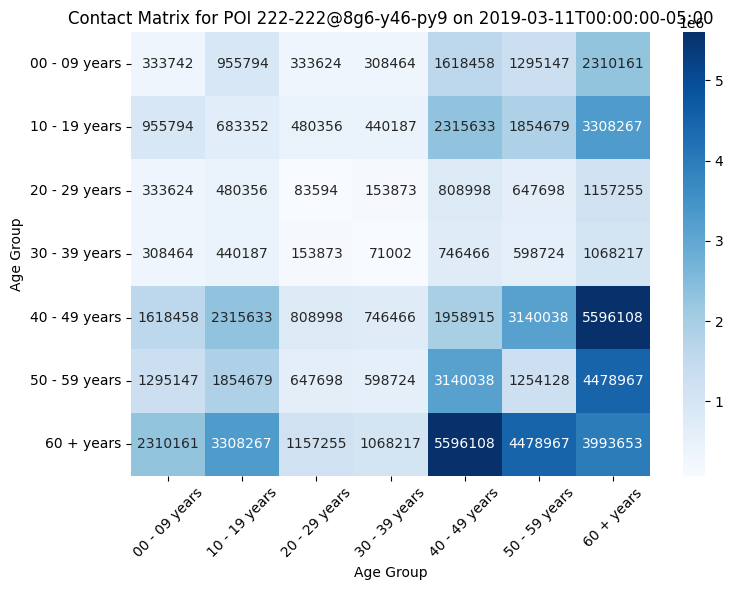

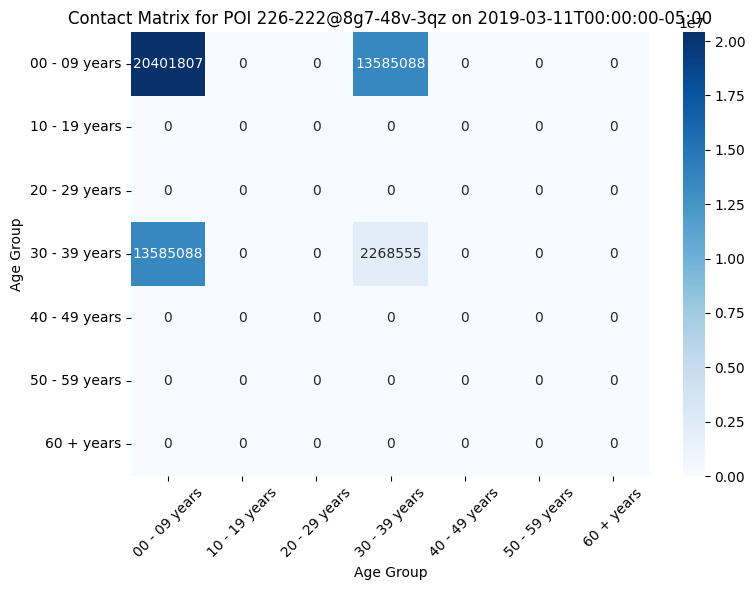

In [12]:
# Loop through and plot each contact matrix
for (poi_id, week), matrix in contact_matrices.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=matrix.columns, yticklabels=matrix.index)
    plt.title(f'Contact Matrix for POI {poi_id} on {week}')
    plt.xlabel('Age Group')
    plt.ylabel('Age Group')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()